## Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix # import the scatter_matrix functionality
from sklearn import linear_model # import the linear models
# import the scikit-learn function to compute error
from sklearn.metrics import mean_squared_error, mean_absolute_error  
from sklearn.metrics import r2_score # explained variance score
from math import sqrt

In [2]:
data = pd.read_excel("OSA_DB_UPM.xlsx")
OSA_df = pd.DataFrame(data)

In [3]:
OSA_df.head()

,Patient,Gender,IAH,Weight,Height,Age,Cervical
0,P0002,hombre,29.6,119,174,56,48.0
1,P0004,hombre,19.7,78,168,39,42.0
2,P0005,hombre,9.0,80,173,32,40.0
3,P0006,hombre,2.0,109,190,32,42.0
4,P0007,hombre,34.0,86,169,39,42.0


## Using scikit-learn

In [4]:
OSA_df.set_index("Patient", inplace = True)

In [5]:
### Picking predictor columns

# Get all the columns from the dataframe
columns = OSA_df.columns.tolist()

# Filter the columns to remove ones we don't want
columns = [c for c in columns if c not in ["IAH", "Gender"]]

# Store the variable we'll be predicting on
target = "IAH"

print('Predictors:', columns)

Predictors: ['Weight', 'Height', 'Age', 'Cervical']


In [6]:
### Splitting into train and test sets

# Generate the training set. Set random_state to be able to replicate results
train = OSA_df.sample(frac = 0.8, random_state = 1)

# Select anything not in the training set and put it in the testing set
test = OSA_df.loc[~OSA_df.index.isin(train.index)]

# Print the shapes of both sets
print(train.shape)
print(test.shape)

(510, 6)
(127, 6)


## Train

In [7]:
### Fitting a linear regression

# Initialize the model class
model = linear_model.LinearRegression()

#model= linear_model.Ridge(alpha = 0.5)

# Fit the model to the training data
Trained_model = model.fit(train[columns], train[target])

## Test

In [8]:
### Predicting Error

# Generate our predictions for the test set
predictions = model.predict(test[columns])

# Compute error between our test predictions and the actual values
MSE = mean_squared_error(predictions, test[target])
MAE = mean_absolute_error(predictions, test[target])

print('Mean Squared Error:', MSE, '\nMean Absolute Error:', MAE)

Mean Squared Error: 331.37589706965946 
Mean Absolute Error: 13.56373616139012


In [9]:
print('Variance score: %.2f' % r2_score(test[target], predictions))

Variance score: 0.22


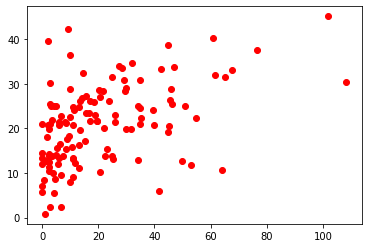

In [10]:
# Plot outputs
plt.scatter(test[target], predictions, color = 'red')
plt.show()

## Using statsmodel

In [11]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [12]:
# Creating X and y
X = OSA_df[columns]
y = OSA_df['IAH']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, 
                                                    test_size = 0.3, random_state = 100)

In [14]:
X_train

,Weight,Height,Age,Cervical
Patient,,,,
P0310,85,168,50,36.0
P0061,90,168,72,45.0
P0426,74,180,39,41.0
P0556,81,158,40,35.0
P0567,73,160,68,36.0
...,...,...,...,...
P0612,160,184,35,50.0
P0058,75,169,51,39.0
P0363,70,160,42,34.0


In [15]:
y_train

Patient
P0310      3.40
P0061     40.00
P0426     20.20
P0556      0.70
P0567     14.00
          ...  
P0612    102.00
P0058      5.00
P0363     21.40
P0085     43.36
P0547      7.20
Name: IAH, Length: 445, dtype: float64

In [16]:
# Adding a constant to get an intercept
X_train_sm = sm.add_constant(X_train)

In [17]:
# Fitting the resgression line using 'OLS'
lr = sm.OLS(y_train, X_train_sm).fit()

# Printing the parameters
lr.params

const      -26.498604
Weight       0.286542
Height      -0.153476
Age          0.237071
Cervical     0.868240
dtype: float64

In [18]:
# Performing a summary to list out all the different parameters of the regression line fitted
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    IAH   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     29.70
Date:                Mon, 18 Jan 2021   Prob (F-statistic):           6.92e-22
Time:                        22:34:46   Log-Likelihood:                -1842.6
No. Observations:                 445   AIC:                             3695.
Df Residuals:                     440   BIC:                             3716.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -26.4986     15.601     -1.698      0.090     -57.161       4.164
Weight         0.2865      0.061      4.662      0.000       0.166       0.407
Height        -0.1535      0.094     -1.628      0.104      -0.339       0.032
Age            0.2371      0.067      3.544      0.000       0.106       0.369
Cervical       0.8682      0.295      2.941      0.003       0.288       1.448
==============================================================================
Omnibus:                       84.629   Durbin-Watson:                   1.850
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.690
Skew:                           1.128   Prob(JB):                     1.04e-31
Kurtosis:                       4.614   Cond. No.                     4.36e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Residual Analysis

In [19]:
# Predicting y_value using training data of X
y_train_pred = lr.predict(X_train_sm)

# Creating residuals from the y_train data and predicted y_data
res = (y_train - y_train_pred)

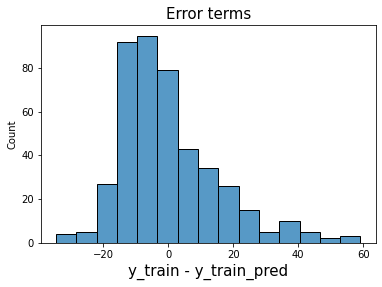

In [20]:
# Plotting the histogram using the residual values
fig = plt.figure()
sns.histplot(res, bins = 15)
plt.title('Error terms', fontsize = 15)
plt.xlabel('y_train - y_train_pred', fontsize = 15)
plt.show()

## Predictions on the Test data or Evaluating the model

In [21]:
# Adding a constant to X_test
X_test_sm = sm.add_constant(X_test)

# Predicting the y values corresponding to X_test_sm
y_test_pred = lr.predict(X_test_sm)

# Printing the first 15 predicted values
y_test_pred

Patient
P0364    35.044890
P0598    18.378154
P0114    12.489499
P0432    13.973699
P0230    21.528058
           ...    
P0115    48.773877
P0253    21.894534
P0594    21.505451
P0586    21.996701
P0172    22.059885
Length: 192, dtype: float64

## Calculate the R Square

In [22]:
# Importing r2_square
from sklearn.metrics import r2_score

# Checking the R-squared value
r_squared = r2_score(y_test, y_test_pred)
r_squared

0.20702267985914335

# <font color='red'> Linear Regression only for males dataset </font>

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [24]:
data = pd.read_excel("OSA_extreme_male.xlsx")
df_OSA_male = pd.DataFrame(data)

In [25]:
df_OSA_male.set_index("Patient", inplace = True)

In [26]:
df_OSA_male.head()

,Gender,IAH,Weight,Height,Age,Cervical,OSA,BMI
Patient,,,,,,,,
P0002,hombre,29.6,119,174,56,48,Severe,39.305060
P0004,hombre,19.7,78,168,39,42,Severe,27.636054
P0005,hombre,9.0,80,173,32,40,Healthy,26.729927
P0006,hombre,2.0,109,190,32,42,Healthy,30.193906
P0009,hombre,22.0,72,165,40,42,Severe,26.446281


In [27]:
df_OSA_male.describe()

,IAH,Weight,Height,Age,Cervical,BMI
count,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000
mean,12.642767,88.572327,175.377358,47.836478,41.575472,28.794656
std,8.344911,14.479817,7.359347,12.715213,2.902022,4.330792
min,0.000000,61.000000,160.000000,20.000000,35.000000,20.061728
25%,5.425000,79.000000,170.000000,38.000000,40.000000,25.780897
50%,11.250000,86.000000,175.000000,47.000000,41.000000,27.991677
75%,19.225000,96.000000,180.000000,58.000000,43.000000,31.215405
max,29.900000,140.000000,196.000000,85.000000,52.000000,43.428571


## Preparing the dataset

In [28]:
X = df_OSA_male[columns]
y = df_OSA_male['IAH']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

## Training the algorithm

In [30]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [31]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
Weight,0.146103
Height,-0.093557
Age,0.189044
Cervical,0.070440


## Making predictions

In [32]:
y_pred = regressor.predict(X_test)

In [33]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
Patient,,
P0516,0.0,9.543319
P0530,25.0,10.520603
P0034,17.0,15.507267
P0129,25.8,14.303529
P0440,15.8,20.093918
...,...,...
P0045,27.0,10.390375
P0004,19.7,10.000046
P0017,22.0,14.488795


## Evaluating the algorithm

In [34]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared:', r2_score(y_test, y_pred))

Mean Absolute Error: 6.643074174083332
Mean Squared Error: 65.57092960139803
Root Mean Squared Error: 8.097587887846482
R-Squared: 0.13439580300094622
